In [15]:
import uproot
import h5py
import numpy as np
from tqdm import tqdm

def make_4tops_dataset(signal_root: str, bkg_root: str, output_h5: str):
    """
    Converts signal and background ROOT files into a HyPER-compatible HDF5 dataset.

    Args:
        signal_root (str): Path to the signal .root file
        bkg_root    (str): Path to the background .root file
        output_h5   (str): Output HDF5 file path
    """
    pad_to_jets = 10 # Max number of jets to pad each event

    # Open the ROOT files
    sig_file = uproot.open(signal_root)
    bkg_file = uproot.open(bkg_root)

    # Trees are usually named "Delphes"
    sig_tree = sig_file["Delphes"]
    bkg_tree = bkg_file["Delphes"]

    # Extract jet variables from signal file
    sig_jet_pt   = sig_tree["Jet.PT"].array(library="np")
    sig_jet_eta  = sig_tree["Jet.Eta"].array(library="np")
    sig_jet_phi  = sig_tree["Jet.Phi"].array(library="np")
    sig_jet_mass = sig_tree["Jet.Mass"].array(library="np")
    sig_njet     = sig_tree["Jet_size"].array(library="np")

    # Extract jet variables from background file
    bkg_jet_pt   = bkg_tree["Jet.PT"].array(library="np")
    bkg_jet_eta  = bkg_tree["Jet.Eta"].array(library="np")
    bkg_jet_phi  = bkg_tree["Jet.Phi"].array(library="np")
    bkg_jet_mass = bkg_tree["Jet.Mass"].array(library="np")
    bkg_njet     = bkg_tree["Jet_size"].array(library="np")

    n_sig = len(sig_jet_pt)
    n_bkg = len(bkg_jet_pt)
    n_tot = n_sig + n_bkg

    print(f"Signal events: {n_sig}")
    print(f"Background events: {n_bkg}")
    print(f"Total events: {n_tot}")

    # Define the structure for each jet (node) in the graph
    node_dt = np.dtype([
        ("pt",   np.float32),
        ("eta",  np.float32),
        ("phi",  np.float32),
        ("mass", np.float32),
    ])

    jet_data = np.zeros((n_tot, pad_to_jets), dtype=node_dt)
    labels = np.zeros((n_tot,), dtype=np.int8)

    offset = 0

    # Fill signal events
    for i in tqdm(range(n_sig), desc="Filling signal", unit="ev"):
        n_jets = min(int(sig_njet[i]), pad_to_jets)
        for j in range(n_jets):
            jet_data[offset][j] = (
                sig_jet_pt[i][j],
                sig_jet_eta[i][j],
                sig_jet_phi[i][j],
                sig_jet_mass[i][j]
            )
        labels[offset] = 1
        offset += 1

    # Fill background events
    for i in tqdm(range(n_bkg), desc="Filling background", unit="ev"):
        n_jets = min(int(bkg_njet[i]), pad_to_jets)
        for j in range(n_jets):
            jet_data[offset][j] = (
                bkg_jet_pt[i][j],
                bkg_jet_eta[i][j],
                bkg_jet_phi[i][j],
                bkg_jet_mass[i][j]
            )
        labels[offset] = 0
        offset += 1

    # Save to HDF5 file
    with h5py.File(output_h5, "w") as h5f:
        inputs_grp = h5f.create_group("INPUTS")
        labels_grp = h5f.create_group("LABELS")

        inputs_grp.create_dataset("jet", data=jet_data, compression="gzip")
        labels_grp.create_dataset("signal", data=labels, compression="gzip")

    print(f"✅ Done! Dataset saved to {output_h5}")

# Example usage (update file paths accordingly)
if __name__ == "__main__":
    signal_file = "C:/Users/sande/Desktop/HeteroData/13TeV_signal.root"
    background_file = "C:/Users/sande/Desktop/HeteroData/13TeV_BKG.root"
    output_file = "4tops_merged.h5"
    make_4tops_dataset(signal_file, background_file, output_file)


Signal events: 1000
Background events: 1000
Total events: 2000


Filling background: 100%|██████████| 1000/1000 [00:00<00:00, 133802.41ev/s]

✅ Done! Dataset saved to 4tops_merged.h5


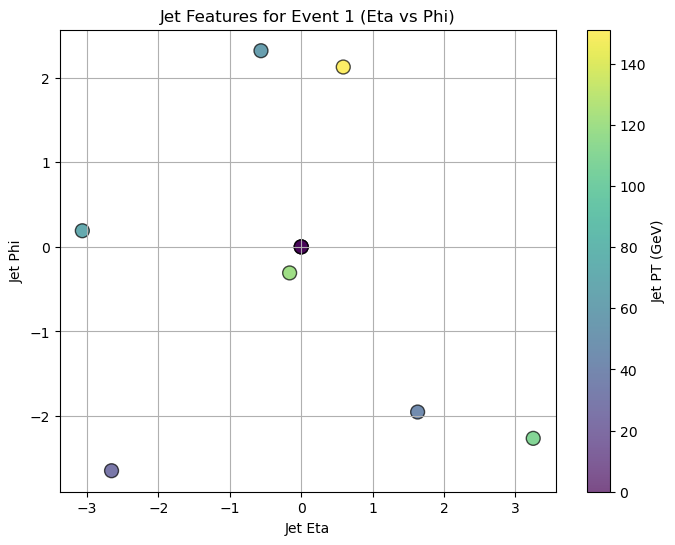

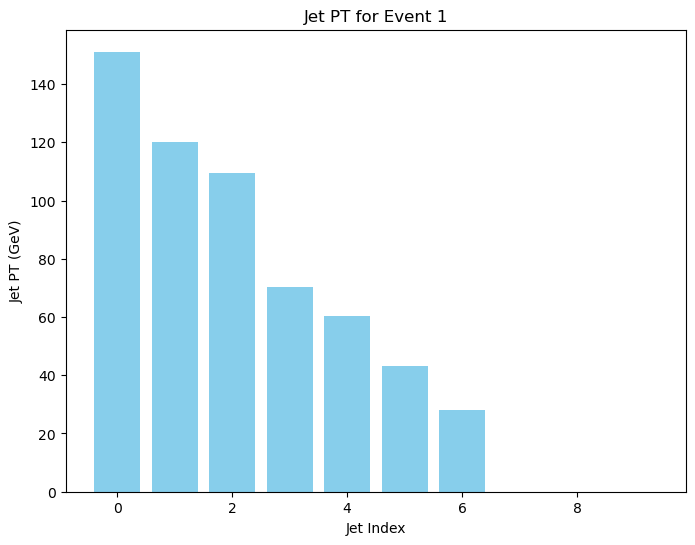

In [16]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Path to the HDF5 file
h5_file = '4tops_merged.h5'

# Load the dataset
with h5py.File(h5_file, 'r') as f:
    jet_data = f['INPUTS/jet'][:]
    labels = f['LABELS/signal'][:]

# Select the features for event 1
event_index = 0  # Event index 0 corresponds to the first event
event_data = jet_data[event_index]  # Jet data for event 1

# Extract jet features for event 1 (pad to 20 jets)
jet_pt = event_data['pt']
jet_eta = event_data['eta']
jet_phi = event_data['phi']
jet_mass = event_data['mass']

# Create scatter plot of eta vs phi for the jets in event 1
plt.figure(figsize=(8, 6))
plt.scatter(jet_eta, jet_phi, c=jet_pt, cmap='viridis', s=100, edgecolors='k', alpha=0.7)
plt.colorbar(label='Jet PT (GeV)')
plt.xlabel('Jet Eta')
plt.ylabel('Jet Phi')
plt.title('Jet Features for Event 1 (Eta vs Phi)')
plt.grid(True)
plt.show()

# Optional: Bar plot for the PT of jets in event 1
plt.figure(figsize=(8, 6))
plt.bar(range(len(jet_pt)), jet_pt, color='skyblue')
plt.xlabel('Jet Index')
plt.ylabel('Jet PT (GeV)')
plt.title('Jet PT for Event 1')
plt.show()


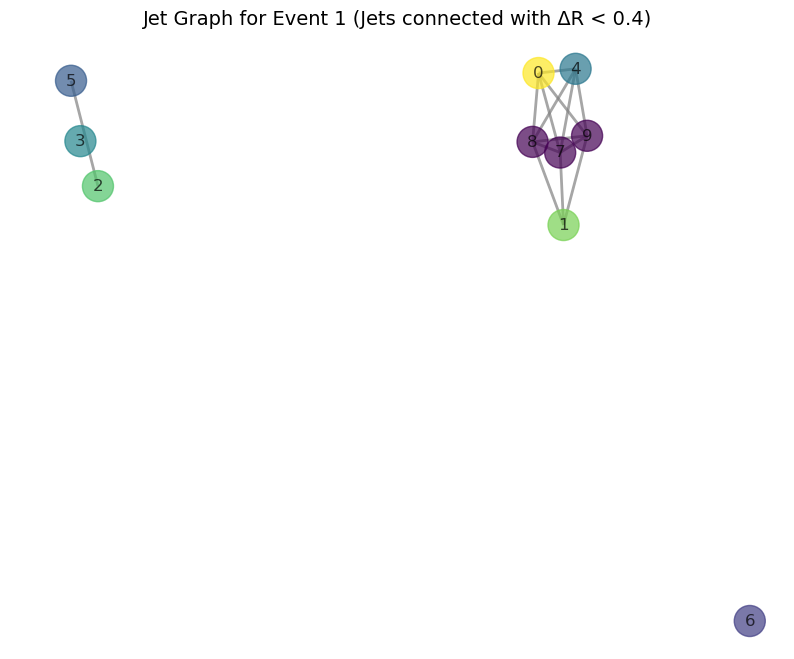

In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Function to calculate ΔR between two jets
def delta_r(eta1, phi1, eta2, phi2):
    return np.sqrt((eta1 - eta2)**2 + (phi1 - phi2)**2)

# Path to the HDF5 file
h5_file = '4tops_merged.h5'

# Load the dataset
with h5py.File(h5_file, 'r') as f:
    jet_data = f['INPUTS/jet'][:]
    labels = f['LABELS/signal'][:]

# Select the features for event 1
event_index = 0  # Event index 0 corresponds to the first event
event_data = jet_data[event_index]  # Jet data for event 1

# Extract jet features for event 1
jet_pt = event_data['pt']
jet_eta = event_data['eta']
jet_phi = event_data['phi']
jet_mass = event_data['mass']

# Create an empty graph
G = nx.Graph()

# Add nodes for each jet
for i in range(len(jet_pt)):
    G.add_node(i, pt=jet_pt[i], eta=jet_eta[i], phi=jet_phi[i], mass=jet_mass[i])

# Add edges based on ΔR < 0.4 condition
for i in range(len(jet_pt)):
    for j in range(i + 1, len(jet_pt)):  # Avoid double counting edges
        dr = delta_r(jet_eta[i], jet_phi[i], jet_eta[j], jet_phi[j])
        if dr < 2.4:  # Add edge if ΔR < 0.4
            G.add_edge(i, j)

# Plot the graph
plt.figure(figsize=(10, 8))

# Define positions for the nodes using a circular layout
pos = nx.spring_layout(G, seed=42)  # Spring layout for better visualization

# Draw the graph
plt.title("Jet Graph for Event 1 (Jets connected with ΔR < 0.4)", fontsize=14)
nx.draw(G, pos, with_labels=True, node_size=500, node_color=jet_pt, cmap='viridis', 
        font_size=12, edge_color='gray', width=2, alpha=0.7)

# Add color bar for the node color (jet pt)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(jet_pt), vmax=max(jet_pt)))
sm.set_array([])  # Empty array for the color bar
# /plt.colorbar(sm, label='Jet PT (GeV)')

plt.show()
